In [2]:
!pip install opencage

In [35]:
# import packages
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import requests
from opencage.geocoder import OpenCageGeocode
import numpy as np
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import json 
import sys
from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
sns.set(color_codes=True)
%matplotlib inline

Down load the CHICAGO Lrail station csv

In [4]:
!wget -O cta.csv https://data.cityofchicago.org/api/views/8pix-ypme/rows.csv?accessType=DOWNLOAD

--2020-04-12 02:57:44--  https://data.cityofchicago.org/api/views/8pix-ypme/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 52.206.68.26, 52.206.140.205, 52.206.140.199
Connecting to data.cityofchicago.org (data.cityofchicago.org)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: 'cta.csv'

     0K .......... .......... .......... .......... ......     25.1M=0.002s

2020-04-12 02:57:44 (25.1 MB/s) - 'cta.csv' saved [47888]



In [2]:
df_cta = pd.read_csv('cta.csv')
df_cta.head()

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,30162,W,18th (54th/Cermak-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
1,30161,E,18th (Loop-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
2,30022,N,35th/Archer (Loop-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
3,30023,S,35th/Archer (Midway-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
4,30214,S,35-Bronzeville-IIT (63rd-bound),35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,True,False,False,True,False,False,False,False,False,False,"(41.831677, -87.625826)"


In [3]:
df_cta.head(50)

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,30162,W,18th (54th/Cermak-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
1,30161,E,18th (Loop-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
2,30022,N,35th/Archer (Loop-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
3,30023,S,35th/Archer (Midway-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
4,30214,S,35-Bronzeville-IIT (63rd-bound),35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,True,False,False,True,False,False,False,False,False,False,"(41.831677, -87.625826)"
5,30213,N,35-Bronzeville-IIT (Harlem-bound),35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,True,False,False,True,False,False,False,False,False,False,"(41.831677, -87.625826)"
6,30246,S,43rd (63rd-bound),43rd,43rd (Green Line),41270,True,False,False,True,False,False,False,False,False,False,"(41.816462, -87.619021)"
7,30245,N,43rd (Harlem-bound),43rd,43rd (Green Line),41270,True,False,False,True,False,False,False,False,False,False,"(41.816462, -87.619021)"
8,30025,S,51st (63rd-bound),51st,51st (Green Line),40130,True,False,False,True,False,False,False,False,False,False,"(41.80209, -87.618487)"
9,30024,N,51st (Harlem-bound),51st,51st (Green Line),40130,True,False,False,True,False,False,False,False,False,False,"(41.80209, -87.618487)"


We only needs the station name, use the Dataframe.drop_duplicates() method.

In [4]:
df_cta.drop_duplicates('STATION_NAME', 'first', inplace=True)
df_cta.head(10)

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,30162,W,18th (54th/Cermak-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
2,30022,N,35th/Archer (Loop-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
4,30214,S,35-Bronzeville-IIT (63rd-bound),35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,True,False,False,True,False,False,False,False,False,False,"(41.831677, -87.625826)"
6,30246,S,43rd (63rd-bound),43rd,43rd (Green Line),41270,True,False,False,True,False,False,False,False,False,False,"(41.816462, -87.619021)"
8,30025,S,51st (63rd-bound),51st,51st (Green Line),40130,True,False,False,True,False,False,False,False,False,False,"(41.80209, -87.618487)"
10,30113,E,54th/Cermak (Loop-bound),54th/Cermak,54th/Cermak (Pink Line),40580,True,False,False,False,False,False,False,False,True,False,"(41.85177331, -87.75669201)"
12,30192,S,69th (95th-bound),69th,69th (Red Line),40990,True,True,False,False,False,False,False,False,False,False,"(41.768367, -87.625724)"
14,30047,S,79th (95th-bound),79th,79th (Red Line),40240,True,True,False,False,False,False,False,False,False,False,"(41.750419, -87.625112)"
16,30089,S,95th/Dan Ryan (95th-bound),95th/Dan Ryan,95th/Dan Ryan (Red Line),40450,True,True,False,False,False,False,False,False,False,False,"(41.722377, -87.624342)"
17,30088,N,95th/Dan Ryan (Howard-bound),95th/Ran Ryan,95th/Ran Ryan (Red Line),40450,True,True,False,False,False,False,False,False,False,False,"(41.722377, -87.624342)"


We notice there is one mistake in 95th/Dan Ryan and 95th/Ran Ryan

In [5]:
df_cta.drop_duplicates('Location', 'first', inplace=True)
df_cta.head(10)

,STOP_ID,DIRECTION_ID,STOP_NAME,STATION_NAME,STATION_DESCRIPTIVE_NAME,MAP_ID,ADA,RED,BLUE,G,BRN,P,Pexp,Y,Pnk,O,Location
0,30162,W,18th (54th/Cermak-bound),18th,18th (Pink Line),40830,True,False,False,False,False,False,False,False,True,False,"(41.857908, -87.669147)"
2,30022,N,35th/Archer (Loop-bound),35th/Archer,35th/Archer (Orange Line),40120,True,False,False,False,False,False,False,False,False,True,"(41.829353, -87.680622)"
4,30214,S,35-Bronzeville-IIT (63rd-bound),35th-Bronzeville-IIT,35th-Bronzeville-IIT (Green Line),41120,True,False,False,True,False,False,False,False,False,False,"(41.831677, -87.625826)"
6,30246,S,43rd (63rd-bound),43rd,43rd (Green Line),41270,True,False,False,True,False,False,False,False,False,False,"(41.816462, -87.619021)"
8,30025,S,51st (63rd-bound),51st,51st (Green Line),40130,True,False,False,True,False,False,False,False,False,False,"(41.80209, -87.618487)"
10,30113,E,54th/Cermak (Loop-bound),54th/Cermak,54th/Cermak (Pink Line),40580,True,False,False,False,False,False,False,False,True,False,"(41.85177331, -87.75669201)"
12,30192,S,69th (95th-bound),69th,69th (Red Line),40990,True,True,False,False,False,False,False,False,False,False,"(41.768367, -87.625724)"
14,30047,S,79th (95th-bound),79th,79th (Red Line),40240,True,True,False,False,False,False,False,False,False,False,"(41.750419, -87.625112)"
16,30089,S,95th/Dan Ryan (95th-bound),95th/Dan Ryan,95th/Dan Ryan (Red Line),40450,True,True,False,False,False,False,False,False,False,False,"(41.722377, -87.624342)"
18,30132,S,Adams/Wabash (Inner Loop),Adams/Wabash,"Adams/Wabash (Brown, Green, Orange, Pink & Pur...",40680,False,False,False,True,False,False,True,False,True,True,"(41.879507, -87.626037)"


In [6]:
df_cta.shape

(108, 17)

In [7]:
df_cta_station = df_cta.loc[:, ['STATION_NAME', 'Location']]
df_cta_station.reset_index(inplace=True)

In [8]:
df_cta_station.drop(columns='index', inplace=True)
df_cta_station.head()

,STATION_NAME,Location
0,18th,"(41.857908, -87.669147)"
1,35th/Archer,"(41.829353, -87.680622)"
2,35th-Bronzeville-IIT,"(41.831677, -87.625826)"
3,43rd,"(41.816462, -87.619021)"
4,51st,"(41.80209, -87.618487)"


In [9]:
print(df_cta_station.loc[0, 'Location'])

(41.857908, -87.669147)


In [10]:
df_cta_station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   STATION_NAME  108 non-null    object
 1   Location      108 non-null    object
dtypes: object(2)
memory usage: 1.8+ KB


In [11]:
#Change Location type from str to turple
from ast import literal_eval
df_cta_station['Location'] = [literal_eval(x) for x in df_cta_station['Location']]

In [20]:
df_cta_station['Location']=df_cta_station['Location'].apply(lambda x:list(x))

In [21]:
df_cta_station.head()

,STATION_NAME,Location
0,18th,"[41.857908, -87.669147]"
1,35th/Archer,"[41.829353, -87.680622]"
2,35th-Bronzeville-IIT,"[41.831677, -87.625826]"
3,43rd,"[41.816462, -87.619021]"
4,51st,"[41.80209, -87.618487]"


### We mark all the station on Chicago Map

In [12]:
chicago_lat=41.881832
chicago_lon=-87.623177

In [32]:
map_chicago = folium.Map(location=[chicago_lat, chicago_lon], zoom_start=10.4)

for station, loc in zip(df_cta_station['STATION_NAME'],
                       df_cta_station['Location']):
    label = '{}'.format(station)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        loc,
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_chicago)

map_chicago

### Get Venues

In [ ]:
CLIENT_ID = '********'
CLIENT_SECRET = '***************'  ###credential from four square
VERSION = '20191201'
radius = 500
LIMIT = 80

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    chicago_lat, 
    chicago_lon, 
    radius, 
    LIMIT)

results = requests.get(url).json()["response"]['groups'][0]['items']
results

In [65]:
def getNearbyVenues(names, locations, radius=2000, Limit=1000):
    venues_list=[]
    for name, loc in zip(names, locations):
#        print(name, loc)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, loc[0], loc[1], radius, LIMIT)
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(name, loc, v['venue']['name'], v['venue']['location']['lat'],v['venue']['location']['lng'],
                            v['venue']['categories'][0]['name']) for v in results])
        
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['CTA Station', 'Station_Location', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    return(nearby_venues)

In [62]:
print(df_cta_station['STATION_NAME'])

0                        18th
1                 35th/Archer
2        35th-Bronzeville-IIT
3                        43rd
4                        51st
                ...          
103                   Chicago
104                      63rd
105    Cermak-McCormick Place
106                    Wilson
107         Washington/Wabash
Name: STATION_NAME, Length: 108, dtype: object


In [66]:
chicago_venues = getNearbyVenues(names=df_cta_station['STATION_NAME'],locations=df_cta_station['Location'])
print(chicago_venues.shape)
chicago_venues.head()

(8420, 6)


,CTA Station,Station_Location,Venue,Venue Latitude,Venue Longitude,Venue Category
0,18th,"[41.857908, -87.669147]",5 Rabanitos,41.857808,-87.670947,Mexican Restaurant
1,18th,"[41.857908, -87.669147]",The Jibarito Stop,41.857789,-87.668101,Latin American Restaurant
2,18th,"[41.857908, -87.669147]",Carnitas Uruapan,41.857545,-87.669672,Mexican Restaurant
3,18th,"[41.857908, -87.669147]",Canton Regio,41.857972,-87.664258,Mexican Restaurant
4,18th,"[41.857908, -87.669147]",Harrison Park,41.857249,-87.673555,Park


In [67]:
chicago_venues.head(80)

,CTA Station,Station_Location,Venue,Venue Latitude,Venue Longitude,Venue Category
0,18th,"[41.857908, -87.669147]",5 Rabanitos,41.857808,-87.670947,Mexican Restaurant
1,18th,"[41.857908, -87.669147]",The Jibarito Stop,41.857789,-87.668101,Latin American Restaurant
2,18th,"[41.857908, -87.669147]",Carnitas Uruapan,41.857545,-87.669672,Mexican Restaurant
3,18th,"[41.857908, -87.669147]",Canton Regio,41.857972,-87.664258,Mexican Restaurant
4,18th,"[41.857908, -87.669147]",Harrison Park,41.857249,-87.673555,Park
...,...,...,...,...,...,...
75,18th,"[41.857908, -87.669147]",Lagunitas Brewing Company,41.857556,-87.692041,Brewery
76,18th,"[41.857908, -87.669147]",Mario's Italian Lemonade,41.869529,-87.653783,Dessert Shop
77,18th,"[41.857908, -87.669147]",Alulu,41.854604,-87.663668,Brewery
78,18th,"[41.857908, -87.669147]",Don's Grill,41.856497,-87.685547,Diner


In [68]:
chicago_venues.to_csv('chicago_venues.csv') #Save the data

In [74]:
###### get the data of all categories to define if it's a food venue
url_cate= url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION)
res_cate = requests.get(url_cate).json()

cdict=[]
ddict=[]
for level1 in res_cate['response']['categories']:
    for level2 in level1['categories']:
        cdict.append([level1['name'],level2['name']])
        if len(level2['categories'])>0:
            for level3 in level2['categories']:
                ddict.append([level2['name'],level3['name']])
                
cdf=pd.DataFrame(cdict,columns=['level1','level2'])
ddf=pd.DataFrame(ddict,columns=['level2','level3'])
catedf=pd.merge(cdf,ddf,on='level2',how='outer')
catedf.to_csv('category.csv')

In [78]:
chicago_venues1 = pd.merge(chicago_venues, 
                  catedf[['level2', 'level3']],
                  left_on='Venue Category',
                  right_on='level3',
                  how='left')
chicago_venues1.loc[chicago_venues1['level2'].isna(),'level2']=chicago_venues1['Venue Category']
chicago_venues1=chicago_venues1.drop(columns=['level3'])
chicago_venues1=chicago_venues1.rename(columns={
    'Venue Category':'Venue Category_temp',
    'level2':'Venue Category'
})
chicago_venues1.head()

,CTA Station,Station_Location,Venue,Venue Latitude,Venue Longitude,Venue Category_temp,Venue Category
0,18th,"[41.857908, -87.669147]",5 Rabanitos,41.857808,-87.670947,Mexican Restaurant,Mexican Restaurant
1,18th,"[41.857908, -87.669147]",The Jibarito Stop,41.857789,-87.668101,Latin American Restaurant,Latin American Restaurant
2,18th,"[41.857908, -87.669147]",Carnitas Uruapan,41.857545,-87.669672,Mexican Restaurant,Mexican Restaurant
3,18th,"[41.857908, -87.669147]",Canton Regio,41.857972,-87.664258,Mexican Restaurant,Mexican Restaurant
4,18th,"[41.857908, -87.669147]",Harrison Park,41.857249,-87.673555,Park,Park


In [79]:
###### filter the different venue category to remain only 2nd level categories
chicago_venues1=pd.merge(chicago_venues1,catedf[['level1', 'level2']],
         left_on='Venue Category',
                  right_on='level2',
                  how='left')
chicago_venues2=chicago_venues1.drop(columns=['level1','level2','Venue Category_temp'])

In [83]:
chicago_venues2=chicago_venues2.drop_duplicates(subset='Venue', keep=False)

In [84]:
chicago_venues2.groupby("Venue Category")['Venue'].count().nlargest(20)

Venue Category
American Restaurant     50
Park                    48
Pizza Place             28
Coffee Shop             16
Bakery                  15
Café                    15
Sushi Restaurant        14
Diner                   13
Breakfast Spot          11
Gym                     11
Fast Food Restaurant    10
Intersection            10
Steakhouse              10
Hot Dog Joint            9
Bus Station              8
Cosmetics Shop           8
Fried Chicken Joint      8
Sandwich Place           8
Seafood Restaurant       8
BBQ Joint                7
Name: Venue, dtype: int64

In [85]:
chicago_venues2.head()

,CTA Station,Station_Location,Venue,Venue Latitude,Venue Longitude,Venue Category
545,18th,"[41.857908, -87.669147]",Alulu,41.854604,-87.663668,Brewery
579,35th/Archer,"[41.829353, -87.680622]",McKinley Park,41.823397,-87.679653,Park
590,35th/Archer,"[41.829353, -87.680622]",The Hut,41.828147,-87.694537,Hot Dog Joint
612,35th/Archer,"[41.829353, -87.680622]",cafeteria yesenia,41.816406,-87.665472,Caribbean Restaurant
613,35th/Archer,"[41.829353, -87.680622]",Brighton Park,41.829921,-87.698386,Park


In [89]:
map_chicago = folium.Map(location = [chicago_lat, chicago_lon], zoom_start = 10.4)

# add markers to map
for lat, lng, station,venue in zip(chicago_venues2['Venue Latitude'], 
                                           chicago_venues2['Venue Longitude'], 
                                            chicago_venues2['CTA Station'], 
                                            chicago_venues2['Venue']):
    label = '{},{}'.format(station,
                              venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=1,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(map_chicago)  

map_chicago

### Level 2 Venues Categories

In [91]:
# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues2[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
chicago_onehot['Neighborhood'] = chicago_venues2['CTA Station'] 

# move neighborhood column to the first column
columns = chicago_onehot.columns.values.tolist()
columns.sort(key = 'Neighborhood'.__eq__)
chicago_onehot = chicago_onehot[columns]

chicago_grouped = chicago_onehot.groupby('Neighborhood').sum().reset_index()
chicago_grouped.head()

,Neighborhood,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Arts & Entertainment,BBQ Joint,...,Thrift / Vintage Store,Toy / Game Store,Trail,Tram Station,Vegetarian / Vegan Restaurant,Video Store,Warehouse,Warehouse Store,Yoga Studio,Zoo
0,18th,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,35th-Bronzeville-IIT,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,35th/Archer,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,47th,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,54th/Cermak,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [93]:
num_top_venues = 8

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = chicago_grouped['Neighborhood']

for ind in np.arange(chicago_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(chicago_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue
0,18th,Brewery,Zoo,Factory,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farm,Falafel Restaurant
1,35th-Bronzeville-IIT,Shipping Store,Café,Deli / Bodega,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farm,Falafel Restaurant
2,35th/Archer,Park,Recycling Facility,Building,Furniture / Home Store,Food,Fast Food Restaurant,Factory,Intersection
3,47th,Food,Park,Fried Chicken Joint,Playground,Seafood Restaurant,Fast Food Restaurant,Farm,Falafel Restaurant
4,54th/Cermak,Diner,Bakery,Caribbean Restaurant,Factory,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farm


In [110]:
kclusters = 4

chicago_grouped_clustering = chicago_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=1,).fit(chicago_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_
#len(kmeans.labels_)#=16
chicago_merged = neighborhoods_venues_sorted

# add clustering labels
chicago_merged['Cluster Labels'] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
chicago_merged = pd.merge(df_cta_station, chicago_merged,left_on='STATION_NAME',right_on='Neighborhood')
chicago_merged.groupby('Cluster Labels')['STATION_NAME'].count()

Cluster Labels
0    21
1     5
2     2
3    51
Name: STATION_NAME, dtype: int64

Draw the 5 clusters on the map

In [103]:
chicago_merged.head()

,STATION_NAME,Location,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,Cluster Labels
0,18th,"[41.857908, -87.669147]",18th,Brewery,Zoo,Factory,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farm,Falafel Restaurant,0
1,35th/Archer,"[41.829353, -87.680622]",35th/Archer,Park,Recycling Facility,Building,Furniture / Home Store,Food,Fast Food Restaurant,Factory,Intersection,4
2,35th-Bronzeville-IIT,"[41.831677, -87.625826]",35th-Bronzeville-IIT,Shipping Store,Café,Deli / Bodega,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farm,Falafel Restaurant,0
3,54th/Cermak,"[41.85177331, -87.75669201]",54th/Cermak,Diner,Bakery,Caribbean Restaurant,Factory,Flower Shop,Fish & Chips Shop,Fast Food Restaurant,Farm,0
4,69th,"[41.768367, -87.625724]",69th,American Restaurant,Intersection,Park,Fast Food Restaurant,Tram Station,Salad Place,Bookstore,Zoo,4


In [111]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location = [chicago_lat, chicago_lon], zoom_start=10.4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
# color = [colors.rgb2hex(i) for i in colors_array]
color=['red','green','black','blue']


# add markers to the map
markers_colors = []
for loc, poi, cluster in zip(chicago_merged['Location'], chicago_merged['Neighborhood'], chicago_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        loc,
        radius=5,
        popup=label,
        color=color[cluster-1],
        fill=True,
        fill_color=color[cluster-1],
        fill_opacity=1).add_to(map_clusters)
       
map_clusters

In [112]:
grouped = chicago_merged[['Neighborhood',
                     'Cluster Labels',
                     '1st Most Common Venue', 
                     '2nd Most Common Venue', 
                     '3rd Most Common Venue',
                     '4th Most Common Venue',
                     '5th Most Common Venue','6th Most Common Venue'
                    ]]

grouped.loc[:, 'Top Venues'] = grouped.apply(lambda x: ", ".join(x.iloc[2:5]), axis=1)
grouped = grouped.drop(['1st Most Common Venue', 
                        '2nd Most Common Venue', 
                        '3rd Most Common Venue',
                     '4th Most Common Venue',
                     '5th Most Common Venue','6th Most Common Venue'], axis=1)
def mix(group):
    return ', '.join(group['Top Venues'].tolist())
top_venues = grouped.groupby('Cluster Labels').apply(mix)

c0dist = grouped.groupby('Cluster Labels').get_group(0).shape[0]
clr0 = pd.Series(top_venues[0].split(', '), name='Cluster 0').value_counts().nlargest(5)/c0dist
c1dist = grouped.groupby('Cluster Labels').get_group(1).shape[0]
clr1 = pd.Series(top_venues[1].split(', '), name='Cluster 1').value_counts().nlargest(5)/c1dist
c2dist = grouped.groupby('Cluster Labels').get_group(2).shape[0]
clr2 = pd.Series(top_venues[2].split(', '), name='Cluster 2').value_counts().nlargest(5)/c2dist
# c3dist = grouped.groupby('Cluster Labels').get_group(3).shape[0]
# clr3 = pd.Series(top_venues[3].split(', '), name='Cluster 3').value_counts().nlargest(5)/c3dist

(array([0, 1, 2]), <a list of 3 Text major ticklabel objects>)

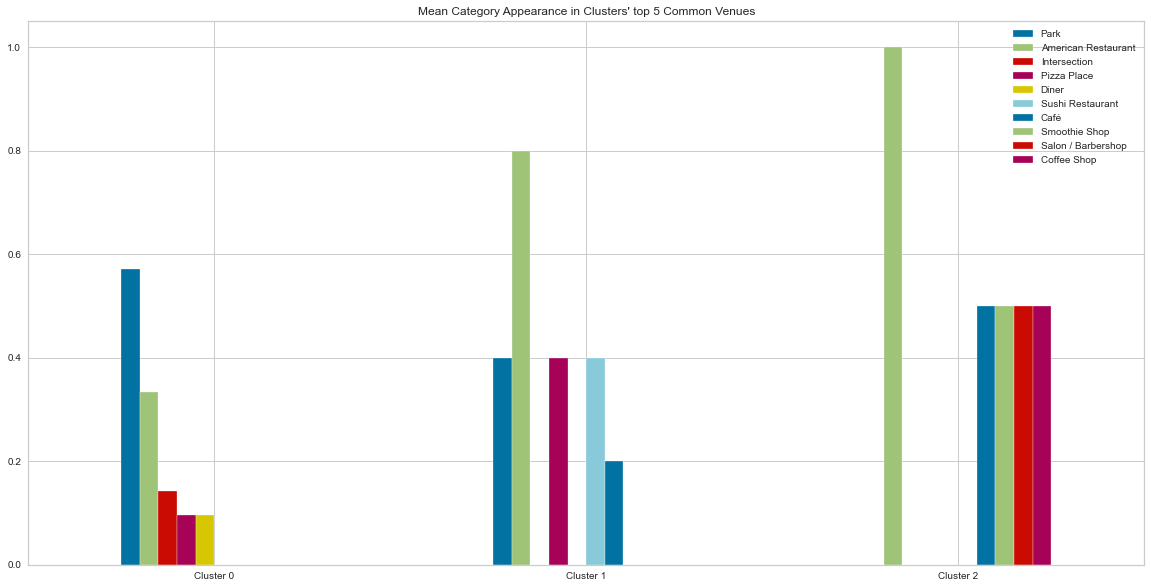

In [113]:
ax = pd.concat([clr0,clr1,clr2], sort=False, axis=1).transpose().plot(kind='bar', figsize=(20, 10))
plt.title("Mean Category Appearance in Clusters' top 5 Common Venues") 
plt.xticks(rotation=0)

Conclusion: Cluster 0 has most park, Cluster 1 and 2 have most american restaurants. 